[Table of Contents](http://nbviewer.ipython.org/github/rlabbe/Kalman-and-Bayesian-Filters-in-Python/blob/master/table_of_contents.ipynb)

# Particle Filters

In [1]:
#format the book
%matplotlib inline
%load_ext autoreload
%autoreload 2  
from __future__ import division, print_function
import matplotlib.pyplot as plt
import book_format
book_format.load_style()

## Motivation

Here is our problem. We have object moving in a space, and we want to track them. Maybe the objects are fighter jets and missiles in the sky, or maybe we are tracking people playing cricket in a field. It doesn't really matter. Which of the filters that we have learned can handle this problem? Well, none of them are ideal. Let's think about the characteristics of this problem. 

1. **multi-modal**: We want to track zero, one, or more than one object simultaneously.

2. **occlusions**: One object can hide another, causing there to be only one measurement for multiple objects.

3. **nonlinear behavior**: Aircraft are buffeted by winds, balls move in parabolas, and people collide into each other.

4. **nonlinear measurements**: Radar gives us the distance to an object. Converting that to an (x,y,z) coordinate requires a square root, which is nonlinear.

5. **non-Gaussian noise:** as objects move across a background the computer vision can mistake part of the background for the object. 

6. **continuous:** the object's position and velocity (i.e. the state space) can smoothly vary over time.

7. **multivariate**: we want to track several attributes, such as position, velocity, turn rates, etc.

None of the filters we have learned work well with all of these constraints. 

* **Discrete Bayes filter**: This has most of the attributes. It is multimodal, can handle nonlinear measurements, and can be made to work with nonlinear behavior (in this book we only handled the linear case). However, it is discrete, not continuous, and it is *univariate*, not multivariate.

* **Kalman filter**: The Kalman filter produces optimal estimates for unimodal linear systems with Gaussian noise. None of these are true for our problem.

* **Unscented Kalman filter**: The UKF handles nonlinear, continuous, multivariate problems. However, it is neither multimodal nor does it handle occlusions. It can handle noise that is modestly non-Gaussian, but does not do well with distributions that are very non-Gaussian or problems that are very nonlinear.

* **Extended Kalman filter**: The EKF has the same strengths and limitations as the UKF, except that is it even more sensitive to strong nonlinearities and non-Gaussian noise.

## Monte Carlo Sampling

In the UKF chapter I generated a plot similar to this to illustrate the effects of nonlinear systems on Gaussians:

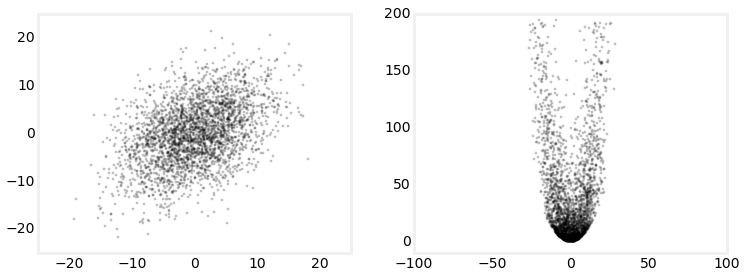

In [2]:
import pf_internal
pf_internal.plot_monte_carlo_ukf()

On the left I created 3000 points normally distributed based on the Gaussian

$$\mu = \begin{bmatrix}0\\0\end{bmatrix},\, \, \, \Sigma = \begin{bmatrix}32&15\\15&40\end{bmatrix}$$


and passed them through the system

$$\begin{aligned}x&=x+y\\
y &= 0.1x^2 + y^2\end{aligned}$$ 

I then showed how poorly the EKF did at estimating the new mean and covariance compared to the UKF.

This technique of using a finite number of randomly sampled to compute a result is called a **Monte Carlo** (MC) method. The idea is simple. Generate *enough* points to get a representative sample of the problem, run the points through the system you are modeling, and then compute the results on the transformed points. 


In a nutshell this is what particle filtering is. A bit later I'll demonstrate how MC can integrate over a probability distribution, but you don't need that formality to understand how they work. It's very simple. It is just the Bayesian filter algorithm we have been using throughout the book applied to thousands of particles, where each particle represents a *possible* state for the system. We extract the estimated state from the thousands of particles using weighted statistics of the particles.


** Generic Particle Filter Algorithm**

1. **Randomly generate a bunch of particles**
    
  Particles can have position, heading, and/or whatever other state variable you need to estimate.
  Each has a weight indicating how likely it matches the actual state of the system.
  
2. **Predict next state of the particles**

  Advance the particles to the next time step based on a system model and noise model.
  
3. **Update**

  Update the weighting of the particles based on a measurement.
  
4. **Resample**

  Discard highly improbable particle and replace them with copies of more probable particles
  
  Optionally, compute mean and covariance of the set of particles to get the most likely current state.
  
  
  
  
This naive algorithm runs into some practical difficulties which we will need to overcome, but this is the general idea. To demonstrate this I wrote a particle filter that performs robot localization. This is the same robot localization problem used in the UKF and EKF chapter. In this problem we have a robot that we can control. It has sensors that measure its distance to various landmarks, and we can steer the robot. Both the sensors and control mechanism have noise in them, and we need to estimate the robot's position.

Here I run a particle filter and plotted the positions of the particles. The plot on the left is after one iteration, and on the right is after 10. The red 'X' shows the actual position of the robot, and the large circle is the computed weighted mean position.

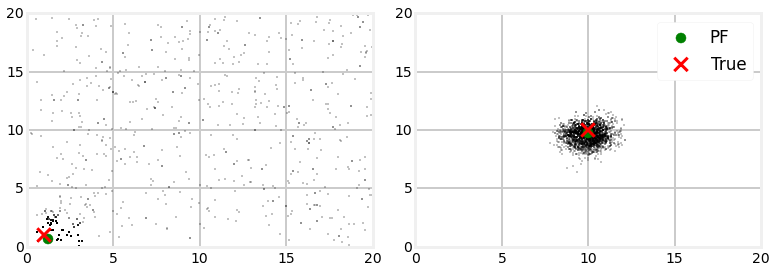

In [71]:
pf_internal.show_two_pf_plots()

After the first iteration the particles are still largely randomly scattered around the map, but you can see that some have already collected near the robot's position. The computed mean is quite close to the robot's position. This is because each particle is weighted based on how closely it matches the measurement. The measurement (with noise) says the robot is near (1,1), so particles that are near (1, 1) will have a high weight, and particles at, say, (15, 19.5) will have a very low weight. The estimated  is computed as the weighted mean of all of the particle's positions, so the estimate is quite accurate. This is partially the result of the random number generation - other runs could produce a poor estimate if no particles were particularly near the robot.

Several iterations later you can see that all the particles have clustered around the robot. This is due to the **resampling** step. Resampling discards particles that are very improbable (very low weight) and replaces them with particles with higher probability. There are multiple algorithms for this, and we will discuss them later. 

I haven't fully shown *why* this works nor fully explained the algorithms for particle weighting and resampling, but it should make intuitive sense. Make a bunch of random particles,  move them so they 'kind of' follow the robot, weight them according to how well they match the measurements, only let the likely ones live, and continue. It seems like it should work, and it does. 

## Probability distributions via MC
Suppose we want to know the area under the curve $y= \mathrm{e}^{\sin(x)}$ in the interval [0, $\pi$]. We can compute the area with the definite integral $\int_0^\pi  \mathrm{e}^{\sin(x)}\, \mathrm{d}x$. As an exercise, go ahead and compute the answer; I'll wait. If you are wise you did not take that challenge; $y=  \mathrm{e}^{\sin(x)}$ cannot be integrated and so you can not find the answer this way.

However, this is trivial to compute using a Monte Carlo technique. Create a bounding box that contains the curve in the desired interval, generate random pairs $(x,y)$, and count how many fall under the curve. Multiply the area of the bounding box by the ratio of points that were under the curve vs the total number of points and you will have computed the are under the curve. As you tend towards infinite points you can achieve any arbitrary precision. In practice, a few thousand points will give you a fairly accurate result.

Think of how powerful this technique is. You can use it to numerically integrate any function. The function can be of any arbitrary difficulty, including being non integrable and noncontinuous, and yet we can trivially find the answer. 

Let's use it to compute $\pi$ by computing the area of a circle. This is very easy. We will create a circle with radius 1, and bound it in a square. The means that the length of a side of the box will be 2, and hence the area of the box is 4. We will generate a set of uniformly distributed random points within the box, and count how many fall inside the circle. The area of the circle is then the area of the box times the ratio of points inside the circle over the total number number of points. Finally, we know that $A = \pi r^2$, so $\pi = A / r^2$.

We start by creating the points.

    N = 20000
    ps = uniform(-1, 1, (N, 2))

A point is inside the circle if it's distance from the center point (0, 0) is less than or equal to one. We can compute the distance by using `numpy.linalg.norm`. If you aren't familiar with this, the norm is the magnitude of a vector. Since vectors start at (0, 0) calling norm will compute the point's distance from the origin.

    dist = np.linalg.norm(ps, axis=1)

Next we compute which of this distances fit the criteria with this code, which returns a bool array that contains `True` if it meets the condition

    in_circle = dist <= 1

All that is left is to count the points inside the circle, compute pi, and plot the results. I've put it all in one cell so you can experiment with alternative values for `N`.

mean pi(N=20000)= 3.1684
err  pi(N=20000)= -0.0268


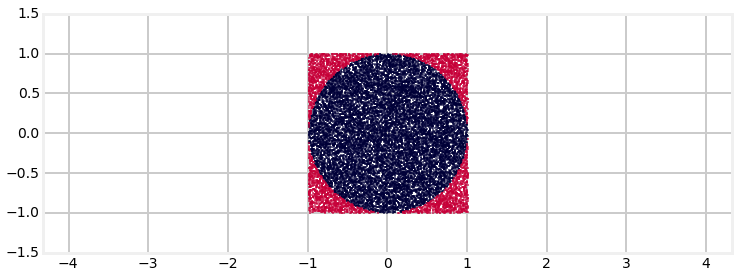

In [4]:
import numpy as np
from numpy.random import uniform 

N = 20000
ps = uniform(-1, 1, (N, 2))
dist = np.linalg.norm(ps, axis=1)
in_circle = dist <= 1

in_circle_count = np.count_nonzero(in_circle)
area = 2*2
pi = area*(in_circle_count / N)

plt.scatter(ps[in_circle,0], ps[in_circle,1], marker=',', edgecolor='k', s=1)
plt.scatter(ps[~in_circle,0], ps[~in_circle,1], marker=',', edgecolor='r', s=1)
plt.axis('equal')

print('mean pi(N={})= {:.4f}'.format(N, pi))
print('err  pi(N={})= {:.4f}'.format(N, np.pi-pi))

I show this to you to help illustrate that you really are computing a numerical integration. An alternative way to find the area of a circle is by integrating the infinitely many circles that lie inside the circle:

$$A = \int_0^{2\pi r} 2\pi t\, dt = \pi r^2 $$

The Monte Carlo technique does something very similar by summing the infinite number of points inside the circle. Computers can't sum infinities, so we settle for a representative sampling of points and less than infinite precision in the results. Using Monte Carlo for this problem is remarkably unnecessary, but imagine instead trying to find the area inside a fractal Mandelbrot set. As far as I know there is no analytic solution to that problem, yet we could use the code above to find the answer. MC is a powerful tool to reach for when analysis fails. 

This insight leads us to the realization that we can use Monte Carlo to compute the probability density of any probability distribution. For example, suppose we have a Gaussian. The Gaussian has a  probability distribution as shown below.

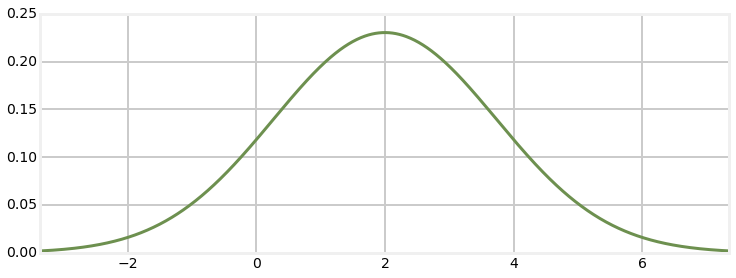

In [5]:
from stats import plot_gaussian
plot_gaussian(mean=2, variance=3)

The *probability density function* (PDF) is the probability that the random value falls between 2 values. For example, we may want to know the probability of x being between 0 and 2 in the graph above. This is a continuous function, so we need to take the integral to find the area under the curve, as the area is equal to the probability for that range of values to occur. 
 
$$P[a \le X \le b] = \int_a^b f_X(x) \, dx$$

It is easy to compute this integral for a Gaussian. But real life is not so easy. For example, the plot below shows a possible and realistic probability distribution. There is no way to analytically describe the curve, let alone integrate it symbolically.

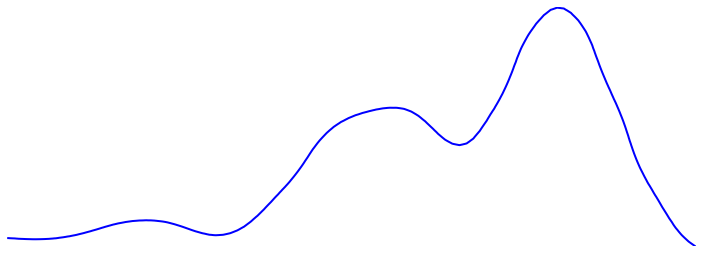

In [6]:
pf_internal.plot_random_pd()

But we have already stated that we can use Monte Carlo methods to compute any integral. The PDF is computed with an integral, hence we can compute the PDF of this curve using Monte Carlo. 

## The Particle Filter

All of this brings us to the particle filter. Consider tracking a robot or a car in an urban environment. For consistency I will use the robot localization problem from the ends of the EKF and UKF chapters. In this problem we tracked a robot that had a sensor that could detect the range and bearing to landmarks. 

Before I continue let me point out that the filter I am going to develop next is a specific form of particle filter that is intuitive to grasp and relates to the problems we have studied in this book. In other words, particle filters are a family of algorithms. A more academic approach would give you a better grasp of this family and the interrelationships between the algorithms, but as in previous chapters I choose to develop concepts based on examples and basic reasoning, and only once that is done go back and develop the theory. This will leave a few of the steps seeming a bit 'magical' since I haven't offered full explanation for their use. Full explanations will follow later in the chapter.

Taking insight from the discussion in the previous section we start by creating several thousand **particles**. Each particle has a position that represents a possible belief of where the robot is in the scene, and perhaps a heading and velocity. Suppose that when we initialize the filter we have no knowledge of the location of the robot. We would want to scatter the particles uniformly over the entire scene. If there was a large clump of particles near a specific location that would imply that we were more certain that the robot is there. If you think of all of the particles representing a probability distribution, locations where there are more particles represent a higher belief, and locations with fewer particles represents a lower belief.

Think back to the *Discrete Bayes* chapter. In that chapter we modeled positions in a hallway as discrete and uniformly spaced. This is very similar except the particles are randomly distributed.

Each particle needs a weight - ideally the probability that it represents the true position of the robot. This probability is rarely computable, so we only require it be *proportional*  to that probability, which is computable. At initialization we have no reason to favor one particle over another, so we would typically assign a weight of $1/n$, where $n$ is the number of particles. We did the same thing in the discrete Bayes chapter. When we initialized the filter we assigned a probability of 1/N to each hallway position. The reason for $1/n$ is simple - the sum of all probabilities must equal one, and of course $\sum\limits_{i=1}^n \frac{1}{n} = 1$.

We will be operating on many particles so it is imperative that we are as efficient in our programming as possible. That means storing the particles in an NumPy `array` and making full use of vectorization and ufuncs.

To track our robot we need to maintain states for x, y, and heading. We will store `N` particles in a `(N, 3)` shaped array. The three columns contain x, y, and heading, in that order.

In this problem the robot can move on a plane of some arbitrary dimension, with the lower right corner at (0,0).

Here is a partial implementation of this problem. The particles are initially randomly distributed over the space, and are given a random heading. 

In [7]:
import numpy as np
from numpy.random import uniform

class ParticleFilter(object):

    def __init__(self, N, x_dim, y_dim, landmarks, measure_std_error):
        self.N = N
        self.x_dim = x_dim
        self.y_dim = y_dim
        self.landmarks = landmarks
        self.R = measure_std_error

        # distribute particles randomly with uniform weight
        self.weights = np.empty(N)
        self.weights.fill(1./N)

        self.particles = np.empty((N, 3))  # x, y, heading        
        self.particles[:, 0] = uniform(0, x_dim, size=N)
        self.particles[:, 1] = uniform(0, y_dim, size=N)
        self.particles[:, 2] = uniform(0, 2*np.pi, size=N)

### Predict Step

The predict step in the Bayes algorithm predicts the movement of the robot and to update our belief in the robot's position by that movement. How would we do that with particles? Each particle represents a possible position for the robot. Suppose we send a command to the robot move 0.1 meters while turning 0.0073 radians. We would want to update each particle by moving it using the same command. If we did that exactly we would soon run into a problem. The robot's controls are not perfect so it will not move exactly as commanded. Therefore we need to add noise to the particle's movements to have a reasonable chance of capturing the actual movement of the robot. If you do not model the uncertainty in the system the particle filter will not correctly model the probability distribution of our belief in the robot's position. 

If this wasn't a robot, but something you are tracking passively, then you would want to include things like velocity in the particle state and use that estimate to make the prediction. When using particle filters I try to minimize the dimensionality of the problem; if I add 2 random variables I will probably have to increase the number of particles to ensure I have enough samples to correctly sample from the probability distribution of each. This can quickly become intractable. Thus I've excluded velocity from this problem.

I cannot easily modify a class definition in Jupyter Notebook, so I will show you the method in text. The entire class is in pf_internal, and we will be importing when we run the filter. 

    def predict(self, u, std, dt=1.):
        """ move according to control input u (heading change, velocity) 
        with noise std"""

        self.particles[:, 2] += u[0] + randn(self.N) * std[0]
        self.particles[:, 2] %= 2 * np.pi

        d = u[1]*dt + randn(self.N) * std[1]
        self.particles[:, 0] += np.cos(self.particles[:, 2]) * d
        self.particles[:, 1] += np.sin(self.particles[:, 2]) * d

### Update Step

Next we get a set of measurements - one for each landmark currently in view. How should these measurements be used to alter our probability distribution as modeled by the particles?

Think back to the *Discrete Bayes* chapter. In that chapter we modeled positions in a hallway as discrete and uniformly spaced. We assigned a probability to each position. When a new measurement came in we multiplied the current probability of that position by the probability that the measurement matched that location. We implemented that like this:

    def update(map_, belief, z, prob_correct):
        scale = prob_correct / (1. - prob_correct)
        for i, val in enumerate(map_):
            if val == z:
                belief[i] *= scale
        normalize(belief)

We will want to do the same thing with our particles. Each particle has a position. We can also assign it a weight or probability based on how well it matches the measurement. We will want to multiply that new probability into the current weight of the particle. If we then normalize the weights of the particles those that are closest to the robot will generally have a higher weight than ones far from the robot.

    def update(self, z):
        self.weights.fill(1.)
        for i, landmark in enumerate(self.landmarks):
            dist = np.linalg.norm(self.particles[:, 0:2] - landmark, axis=1)
            self.weights *= scipy.stats.norm(dist, self.R).pdf(z[i])
        self.weights /= sum(self.weights) # normalize


In the literature this part of the algorithm is called **Sequential Importance Sampling**, or SIS, and the equation for the weights is called the **importance density**. I will give it theoretical underpinnings in a following section. For now I hope that this makes intuitive sense. If we weight the particles according to how how they match the measurements they *probably* are a good sample for the probability distribution of the system after incorporating the measurements. Theory changes 'probably are a good sample' to 'are a good sample'. Different problems will need to tackle this step in slightly different ways.

** AUTHORS NOTE: NO. WE ARE SAMPLING FROM EVOLUTION USING IS TO GET POSTERIOR**


And that is the general framework for the particle filter. The particles and their weights represent the probability distribution of our belief. This algorithm works well for multiple objects; clusters of particles will group around each object. We can compute the position of the robot by computing the mean of the point positions multiplied by their weights. If we have multiple  objects we have to run some sort of clustering algorithm to determine which particles belong to which object, but that isn't hard. 

This is a nearly complete implementation of a particle filter using the Bayesian framework that we have used throughout the book. It is not quite functional in practice due to some problems which I will address in subsequent sections.

I want to emphasize that as with the other filters we are using Bayes Theorem in the update step. Compare the Bayes equation to `update()` and you will see why I assert this.

$$P(A|B) = \frac{P(B|A) P(A)}{P(B)}$$

**author's note - need more than 'look, similar' here!**

### Computing the Estimate

In most applications you will want to know the estimated state after each update, but the filter consists of nothing but a collection of particles. Assuming that we are tracking one object (i.e. it is unimodal) we can compute the mean of the estimate as the sum of the weighted values of the particles. 

$$ \mu = \frac{1}{N}\sum\limits_{i=1}^N w^ix^i$$

Here I use the notation $x^i$ to indicate the i$^{th}$ particle. A superscript is used because we often need to use subscripts to denote time steps the k$^{th}$ or k+1$^{th}$ particle, yielding the unwieldy $x^i_{k+1}$. I'm not partial to this notation but it is what is used in the literature.

This equation seems to be reasonable, but is it? I will discuss this in the *Importance Sampling* section below. For now, just know that the answer is yes, it is reasonable. 

### Particle Resampling

I mentioned problems that the SIS algorithm has. One is called the **degeneracy problem**. We initialize a large area with uniformly distributed particles. The number of particles near the robot are likely to be low. As we perform the algorithm above any particle modestly far from the robot will quickly acquire an extremely low weight, and only one or two particles near the robot with has an appreciable weight. The filter requires hundreds to thousands of particles to adequately sample the probability distribution.  Only one or two near the robot are not enough.

This problem is solved by some form of **resampling** of the particles. If most of the particles have a very small weight this means that most particles are not a very good representation of the probability distribution of the robot. The simplest resampling algorithm endevours to discard particles with very low probability (low weights) and replaces them with particles with higher probability. These particles are taken from the current particle set. This means that some of our particles will be duplicated, but this is not a problem because during the predict step we will be adding random noise to each, so they will separate from their twins. 

One way to accomplish this is to sample from the current particle set `N` times, making a new set of particles from the sample. For this to work the probability of selecting any given particle should be proportional to its weight. The easiest way to accomplish this is to use NumPy's `cumsum` function. `cumsum` computes the *cumulative* sum of an array. That is, element one is the sum of elements zero and one, element two is the sum of elements zero and one, etc. Then we generate random numbers in the range of 0.0 to 1.0 and do a binary search to find the weight that most closely matches that number. This algorithm is variously called **multinomial resampling** or **simple random resampling**.  Here is my implementation:

    def resample(self):
        cumulative_sum = np.cumsum(self.weights)
        cumulative_sum[-1] = 1. # avoid round-off error
        indexes = np.searchsorted(cumulative_sum, random(self.N))
        
        # resample according to indexes
        self.particles = self.particles[indexes]
        self.weights = self.weights[indexes]
        self.weights /= np.sum(self.weights) # normalize
 
There are many resampling algorithms. Each has different properties with respect to which particles are sampled, execution time, and memory required. I will share a few of them in a later section.

You will not necessarily want to resample every iteration. For example, if you received no new measurements you have not received any information from which the resample can benefit. We can determine when to resample by using something called the **effective N**, which is meant to approximate the number of particles with have an appreciable weight which meaningfully contributes to the probability distribution. The equation for this is

$$\hat{N}_{eff} = \frac{1}{\sum w^2}$$

and we can implement this in Python with

    def neff(self):
        return 1. / np.sum(np.square(self.weights))


If $\hat{N}_{eff}$ falls below some threshold it is time to resample. A useful starting point is $\frac{1}{2}N$, but this varies by problem. It is also possible for $\hat{N}_{eff} = N$, which means the particle set has collapsed to one point (each has equal weight). It may not be theoretically pure, but if that happens I create a new distribution of particles in the hopes of generating particles with more diversity. If this happens to you often, you may need to increase the number of particles, or otherwise adjust your filter. We will talk more of this later.

## SIR Filter  - A Complete Example

There is more, but we have covered enough to implement a full particle filter. The filter in this form is called the **Sampling Importance Resampling filter**, or SIR.

The code above has been placed in the file *./code/RobotLocalizationParticleFilter.py* which we will import. If you want to read the source code, comment out the %load command in the next cell and press ctrl-return to execute it.

To implement a particle filter we need to create the landmarks and the filter. We then execute a loop, successively calling `predict`, `update`, and `resample`. The class includes a method named `estimate` which computes the weighted mean and covariance of all the particles

In [8]:
# uncomment to view source code
# %load ./code/RobotLocalizationParticleFilter

final position error, variance: [ 18.00486271  18.00176074] [ 0.00458291  0.00448719]


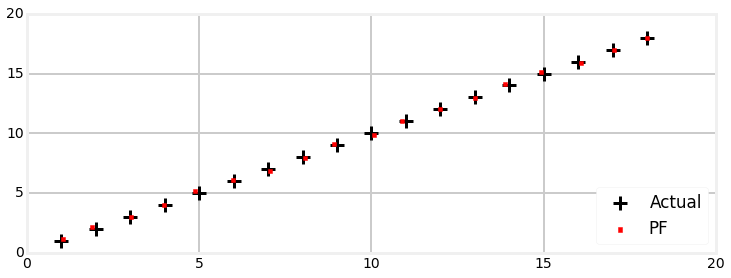

In [56]:
from RobotLocalizationParticleFilter import *
from numpy.linalg import norm

def run_pf1(N, iters=18, sensor_std_err=.1, 
            do_plot=True, plot_particles=False,
            xlim=(0, 20), ylim=(0, 20),
            initial_x=None):
    landmarks = np.array([[-1, 2], [5, 10], [12,14], [18,21]])
    NL = len(landmarks)
    pf = RobotLocalizationParticleFilter(N, 20, 20, landmarks, sensor_std_err)
    if initial_x is not None:
        pf.create_gaussian_particles(mean=initial_x, var=(5, 5, np.pi/4))
        
    if plot_particles:
        alpha = .20
        if N > 5000:
            alpha *= np.sqrt(5000)/np.sqrt(N)           
        plt.scatter(pf.particles[:, 0], pf.particles[:, 1], alpha=alpha, color='g')
    
    xs = []
    pos = np.array([0., 0.])
    for x in range(iters):
        pos += (1, 1) # robot position

        # distance from robot to each landmark
        zs = norm(landmarks - pos, axis=1) + randn(NL)*sensor_std_err

        # move diagonally forward to (x+1, x+1)
        pf.predict((0.00, 1.414), (.2, .05))
        pf.update(z=zs)
        pf.resample()

        mu, var = pf.estimate()
        xs.append(mu)
        if plot_particles:
            plt.scatter(pf.particles[:, 0], pf.particles[:, 1], color='k', marker=',', s=1)
        p1 = plt.scatter(pos[0], pos[1], marker='+', color='k', s=180, lw=3)
        p2 = plt.scatter(mu[0], mu[1], marker='s', color='r')
    
    xs = np.array(xs)
    #plt.plot(xs[:, 0], xs[:, 1])
    plt.legend([p1, p2], ['Actual', 'PF'], loc=4, numpoints=1)
    plt.xlim(*xlim)
    plt.ylim(*ylim)
    print('final position error, variance:', mu, var)

from numpy.random import seed
seed(2) 
run_pf1(N=5000, plot_particles=False)

Most of this code is devoted to initialization and plotting. The entirety of the particle filter processing consists of these lines:

        # distance from robot to each landmark
        zs = norm(landmarks - pos, axis=1) + randn(NL)*sensor_std_err

        # move diagonally forward to (x+1, x+1)
        pf.predict(u=(0.00, 1.414), std=(.2, .05))
        pf.update(z=zs)
        if pf.neff() < N/2:
            pf.resample()

The first line takes advantage of `numpy.linalg.norm`, which computes the Euclidian distance of a vector. In other words, we compute the distance of the robot to each landmark, and add in sensor noise so that this is a realistic simulation. Uou wouldn't add noise if this was real sensor data, of course!

The next line predicts the position of the particles with the assumption that the robot is moving in a straight line (`u[0] == 0`) and moving 1 unit in both the x and y axis (`u[1]==1.414`). The standard deviation for the error in the turn is 0.2, and the standard deviation for the distance is 0.05. When this call returns the particles will all have been moved forward, but the weights are no longer correct as they have not been updated.

The next line incorporates the measurement into the filter. This does not alter the particle positions, it only alters the weights. If you recall the weight of the particle is computed as the probability that it matches the Gaussian of the sensor error model. The further the particle from the measured distance the less likely it is to be a good representation.

The final two lines example the effective particle count ($\hat{N}_{eff})$. If it falls below $\frac{1}{2}N$ we perform resampling to try to ensure our particles form a good representation of the actual probability distribution.

Now let's look at this with all the particles plotted. Seeing this happen interactively is much more useful, but this format still gives us useful information. I plotted the original random distribution of points in a very pale green and large circles to help distinguish them from the subsequent iterations where the particles are plotted with black pixels. The number of particles makes it hard to see the details, so I limited the number of iterations to 8 so we can zoom in and look more closely.

final position error, variance: [ 8.06115913  7.89412269] [ 0.0029203   0.00299334]


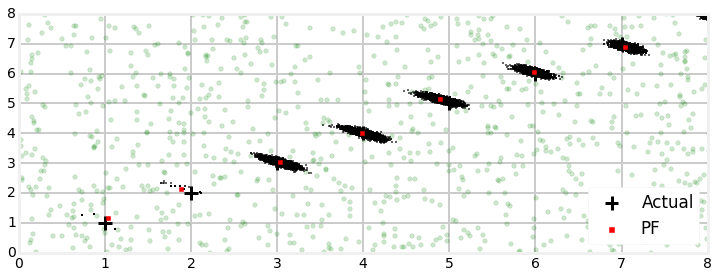

In [57]:
seed(2)
run_pf1(N=5000, iters=8, plot_particles=True, xlim=(0,8), ylim=(0,8))

From the plot it looks like there are only a few particles at the first two robot positions. This is not true; there are 5,000 particles, but due to resampling most are duplicates of each other. The reason for this is the Gaussian for the sensor is very narrow. This is called **sample impoverishment** and can lead to filter divergence. I'll address this in detail below. For now, looking at the second step at x=2 we can see that the particles have dispersed a bit. This dispersion is due to the motion model noise. All particles are projected forward according to the control input `u`, but noise is added to each particle proportional to the error in the control mechanism in the robot. By the third step the particles have dispersed enough to make a convincing cloud of particles around the robot. 

The shape of the particle cloud is an ellipse. This is not a coincidence. The sensors and robot control are both modeled as Gaussian, so the probability distribution of the system is also a Gaussian. The particle filter is a sampling of the probability distribution, so the cloud should be an ellipse.

It is important to recognize that the particle filter algorithm *does not require* the sensors or system to be Gaussian or linear. Because we represent the probability distribution with a cloud of particles we can handle any probability distribution and strongly nonlinear problems. There can be discontinuities and hard limits in the probability model. For example 

### Effect of Sensor Errors on the Filter

The first few iterations of the filter resulted in many duplicate particles. This happens because the model for the sensors is Gaussian, and we gave it a small standard deviation of $\sigma=0.1$. This is  counterintuitive at first. The Kalman filter performs *better* when the noise is smaller, yet the particle filter can perform worse. We can reason why this is true. The standard deviation is just 0.1. This means that if the robot is at (1, 1) and a particle is at (2, 2) the particle is 14 standard deviations away from the sensor. This gives it a near zero probability, and it is extremely unlikely to survive after the resampling. 

This is *very important* to understand - a very accurate sensor can lead to poor performance of the filter because few of the particles will be a good sample of the probability distribution. There are a few fixes available to us. First, we can artificially increase the sensor noise standard deviation so the particle filter will accept more points as matching the robots probability distribution. This is non-optimal because some of those points will be a poor match. The real problem is that there just isn't enough points being generated such that enough are near the robot. Increasing `N` usually fixes this problem. This decision is not cost free as increasing the number of particles significantly increase the computation time. Still, let's look at the result of using 100,000 particles.

final position error, variance: [ 8.03991809  7.93388899] [ 0.00275743  0.00305754]


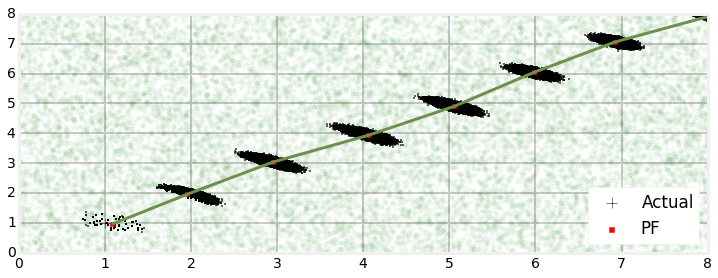

In [37]:
seed(2) 
run_pf1(N=100000, iters=8, plot_particles=True, xlim=(0,8), ylim=(0,8))

There are many more particles at x=1, and we have a convincing cloud at x=2. Clearly the filter is performing better, but if you are running this in your browser you must have noticed how slow the filter ran. 

Another approach is to be smarter about generating the initial particle cloud. Suppose we know that the robot is near (0,0). This is not exact, as the simulation actually places the robot at (1,1), but it is close. If instead of creating a uniform cloud of particles over the entire map we made a normally distributed cloud near (0, 0) there is a much greater chance of the particles matching the robot's position. The particle filter code includes the method `create_gaussian_particles()`; feel free to alter the code above to use this function as in the code snippet below. However, we will be using this in the next section to help with a different problem, so feel free to wait.

        pf = RobotLocalizationParticleFilter(N, 20, 20, landmarks, sensor_std_err)
        pf.create_gaussian_particles(mean=(0, 0), var=(10,10))


### Filter Degeneracy From Inadequate Samples

The filter as written is far from perfect. Here is how it performs with a different random seed.

final position error, variance: [ 13.65600711 -15.87383315] [ 51.52147194  34.40736373]


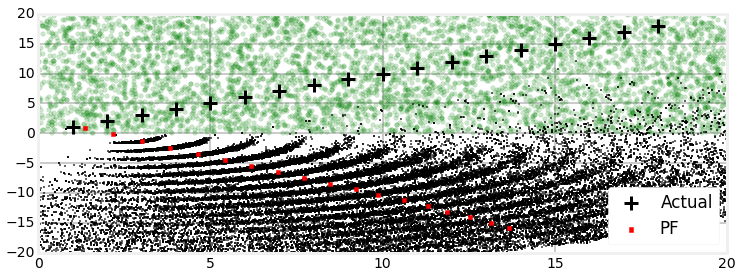

In [58]:
seed(3) 
run_pf1(N=5000, plot_particles=True, ylim=(-20, 20))

Here the initial sample of points did not generate any points near the robot. The particle filter does not create new points during the resample operation, so it ends up duplicating points which are not a representative sample of the probability distribution. As mentioned earlier this is called **sample impoverishment**. The problem quickly spirals out of control. The particles are not a good match for the landscape measurement so they become dispersed in a highly nonlinear, curved distribution, and the particle filter diverges from reality. No particles are available near the robot, so it cannot ever converge.

Let's make use of the `create_gaussian_particles()` method to try to generate more points near the robot. We can do this by using the `initial_x` parameter to specify a location to create the particles.

final position error, variance: [ 17.92304664  18.07173658] [ 0.00451171  0.00429415]


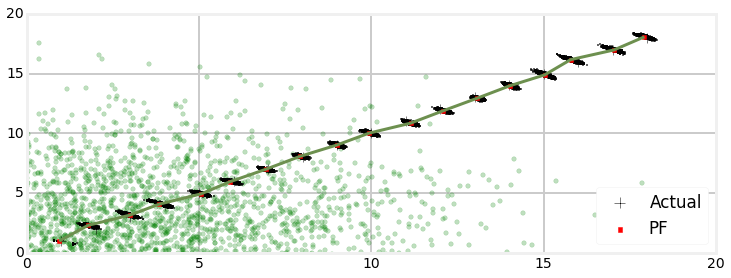

In [30]:
seed(3) 
run_pf1(N=5000, plot_particles=True, initial_x=(1,1, np.pi/4))

This works great. You should always try to create particles near the initial position if you have any way to roughly estimate it. Do not be *too* careful - if you generate all the points very near a single position the particles may not be dispersed enough to capture the nonlinearities in the system. This is a fairly linear system, so we could get away with a smaller variance in the distribution. Clearly this depends on your problem. Increasing the number of particles is always a good way to get a better sample, but the processing cost may be a higher price than you are willing to pay.

##Importance Sampling

In the filter above I hand waved a difficulty away. There is some probability distribution that describes the position and movement of our robot. This might be impossible to integrate analytically, so we want to draw a sample of particles from that distribution and compute the integral using MC methods. 

But our difficulty is that in many problems, including this one, we don't know that distribution. For example, the tracked object might move very differently than we predicted with our state model. How can we draw a sample from a probability distribution that is unknown? 

There is a theorem and associated techniques from statistics called **importance sampling**[1]. It somewhat remarkably gives us a way to draw samples from a *different* and known probability distribution compute the properties of the known one. It's a fantastic theorem that brings joy to my heart. 

The idea is simple, and we already used it. We draw samples from the known probability distribution, but *weight the particles* according to the distribution we are interested in. We can then compute properties such as the mean and variance by computing the weighted mean and weighted variance of the samples.

For the robot localization problem we drew samples from the probability distribution that we computed from our state model prediction step. In other words, we reasoned 'the robot was there, it is perhaps moving at this direction and speed, hence it might be here'. Of course the robot might have done something completely differen. It may have fell off a cliff, been hit by a mortar round or airlifted away, and so on. In each case the probability distribution is not correct. It seems like we are stymied, but we are not because we can use importance sampling. We drew particles from that likely incorrect probability distribution, then weighted them according to how well the particles match the measurements. That weighting is based on the true probability distribution, so according to the theory the resulting mean, variance, etc, will be correct. Magic!

How can that be true? I'll give you the math; you can safely skip this if you don't plan to go beyond the robot localization problem. However, other particle filter problems require different approaches to importance sampling, and a bit of math helps. Also, the literature and much of the content on the web uses the mathematical formulation in favor of my rather imprecise "imagine that..." exposition. If you want to understand the literature you will need to now the following equations.

We have some probability distribution $\pi(x)$ which we want to take samples from. However, we don't know what $\pi(x)$ is; instead we only know an alternative probability distribution $q(x)$. In the context of robot localization, $\pi(x)$ is the probability distribution for the robot, but we don't know it, and $q(x)$ is the probability distribution of our measurements, which we do know.

We can **blah**

$$I = \int f(x)\pi(x)\, \mathsf{d}x$$

We don't know $\pi(x)$ so we cannot compute this integral. We do know $q(x)$ so we can add it into the integral without changing the value with

$$I = \int f(x)\pi(x)\frac{q(x)}{q(x)}\, \mathsf{d}x$$

Now we rearrange and group terms

$$I = \int f(x)q(x)\, \,  \cdot \,  \frac{\pi(x)}{q(x)}\, \mathsf{d}x$$

$q(x)$ is known to us, so we can compute $\int f(x)q(x)$ using MC integration. That leaves us with  $\frac{\pi(x)}{q(x)}$.  That is just a ratio, and we define it as a *weight*. This gives us

$$I = \sum\limits_{i=1}^N f(x^i)w(x^i)$$

Maybe that seems a little abstract. If we want to compute the mean of the particles we would compute

$$\mu = \sum\limits_{i=1}^N x^iw^i$$

which is the equation I gave you earlier in the chapter.

It is required that the weights be *proportional* to the ratio $\frac{\pi(x)}{q(x)}$. We normally do not know the exact value, so in practice we normalize the weights by dividing them by $\sum w(x^i)$.

When you formulate a particle filter algorithm you will have to implement this step depending on the particulars of your situation. For robot localization the best distribution to use for $q(x)$ is the particle distribution from the `predict()` step of the filter. Let's look at the code again:

    def update(self, z):
        self.weights.fill(1.)
        for i, landmark in enumerate(self.landmarks):
            dist = np.linalg.norm(self.particles[:, 0:2] - landmark, axis=1)
            self.weights *= scipy.stats.norm(dist, self.R).pdf(z[i])
        self.weights /= sum(self.weights) # normalize
    
The reason for `self.weights.fill(1.)` might have confused you; it confused me the first time I saw it. In all the Bayesian filters up to this chapter we started with the probability distribution created by the `predict` step, and this appears to discard that information by setting all of the weights to 1. Well, we are discarding the weights, but we do not discard the particles. That is a direct result of applying importance sampling - we draw from the known distribution, but weight by the unknown distribution. 

In other filters you will retain weights in this step. If you can determine the probability distribution directly, for example, it makes no sense to approximate it by sampling from a different probability distribution. The problem you are trying to solve is $I = \int f(x)\pi(x)\, \mathsf{d}x$, and importance sampling give you the tool to do that when $\pi(x)$ is unknown. If you can formulate this more exactly, do so!

**author's note: i don't like this last paragraph; too hand wavey. get specific**

## Resampling Methods

How we resample the particles effects the performance of the filter. For example, suppose we resampled particles by generating a random number from 1 to $N$ and used that as the index of the particle we resample. This would lead us to choosing many particles with a very low weight, and the resulting set of particles would be a terrible representation of the problem's probability distribution. 

There is plenty of room for research and novel algorithms, but research and industry have settled on handful of algorithms that work well in practice across a wide variety of situations. We desire an algorithm that has several properties. It should preferentially select particles that have a higher probability. It should select a representative population of the higher probability particles to avoid sample impoverishment. It should include enough lower probability particles to give the filter a chance of detecting strongly nonlinear behavior. 

I will give you a couple of the most commonly used algorithms; with that information you should be able to search and find alternative should these prove deficient for your application.

FilterPy implements several of the popular algorithms. FilterPy doesn't know how your particle filter is implemented, so it doesn't make sense to have the resample algorithm generate the new samples. Instead, the algorithms just create an ndarray containing the indexes of the weights and particles that are chosen; your class or code needs to perform the resampling step. For example, the robot localization class implements this with

    def resample_from_index(self, indexes):
        assert len(indexes) == self.N

        self.particles = self.particles[indexes]
        self.weights = self.weights[indexes]
        self.weights /= np.sum(self.weights)


### Multinomial Resampling

Multinomial resampling is the algorithm that I used while developing the robot localization example. The idea is simple. Compute the cumulative sum of the normalized weights. This gives you an array of increasing values from 0 to 1. Here is a plot which illustrates how this spaces out the weights. The colors are meaningless, they just make the divisions easier to see.

cumulative sume is [ 0.1  0.3  0.4  1. ]


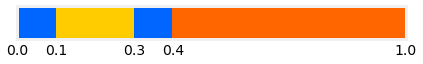

In [22]:
from pf_internal import plot_cumsum
print('cumulative sume is', np.cumsum([.1, .2, .1, .6]))
plot_cumsum([.1, .2, .1, .6])

To select a weight we generate a random number uniformly selected between 0 and 1 and use binary search to find its position inside the cumulative sum array. Large weights will be a further distance from  its neighbors than low weights, so they will be more likely to be selected. 


This is very easy to code using NumPy's ufunc support. `searchsorted` is NumPy's binary search algorithm. If you provide is with an array of search values it will return an array of answers; one answer for each search value. 

    def multinomal_resample(weights):
        cumulative_sum = np.cumsum(weights)
        cumulative_sum[-1] = 1.  # avoid round-off errors
        return np.searchsorted(cumulative_sum, random(len(weights)))
    
Here is an example:

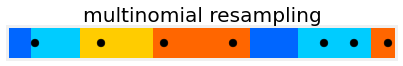

In [15]:
from pf_internal import plot_multinomial_resample
plot_multinomial_resample([.1, .2, .3, .4, .2, .3, .1])

This is an O(n log(n)) algorithm. That is not terrible, but there are O(n) resampling algorithms with better properties with respect to the uniformity of the samples. I show it to you first merely because you can understand the other algorithms as variations on this one. There is a faster implementation of this algorithm that uses the inverse of the CDF of the distribution, but since we will not be using this much, if ever, I won't cover it. You can search on the internet if you are interested.


You may import this from FilterPy using

    from filterpy.monte_carlo import multinomal_resample

### Residual Resampling

Residual resampling both improves the run time of multinomial resampling, and ensures that the sampling is uniform across the population of particles. It's fairly ingenious: the normalized weights are multiplied by *N*, and then the integer value of each weight is used to define how many samples of that particle will be taken. For example, if the weight of a particle is 0.0012 and $N$=3000, the scaled weight is 3.6, so 3 samples will be taken of that particle. This ensures that all higher weight particles are chosen at least once, and has O(N) running time.

However, this does not make *N* selections. To select the rest, we take the *residual*: the weights minus the integer part, which leaves the fractional part of the number. We then use a simpler sampling scheme such as multinomial, to select the rest of the particles based on the residual. In the example above the scaled weight was 3.6, so the residual will be 0.6 (3.6 - int(3.6)). This residual is very large so the particle will be likely to be sampled again. This is reasonable because the larger the residual the larger the error in the round off, and thus the particle was relatively under sampled in the integer step.


    def residual_resample(weights):
        N = len(weights)
        indexes = np.zeros(N, 'i')

        # take int(N*w) copies of each weight
        num_copies = (N*np.asarray(weights)).astype(int)
        k = 0
        for i in range(N):
            for _ in range(num_copies[i]): # make n copies
                indexes[k] = i
                k += 1


        # use multinormial resample on the residual to fill up the rest.
        residual = w - num_copies     # get fractional part
        residual /= sum(residual)     # normalize
        cumulative_sum = np.cumsum(residual)
        cumulative_sum[-1] = 1. # avoid round-off errors: ensures sum is exactly one
        indexes[k:N] = np.searchsorted(cumulative_sum, random(N-k))

        return indexes

You may be tempted to replace the inner for loop with a slice `indexes[k:k + num_copies[i]] = i`, but very short slices are comparatively slow, and the for loop usually runs faster.

Let's look at an example:

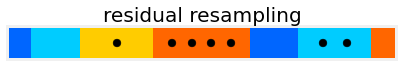

In [16]:
from pf_internal import plot_residual_resample
plot_residual_resample([.1, .2, .3, .4, .2, .3, .1])

You may import this from FilterPy using

    from filterpy.monte_carlo import residual_resample

### Stratified Resampling

This scheme aims to make selections relatively uniformly across the particles. It works by dividing the cumulative sum into $N$ equal sections, and then selects one particle randomly from each section.  This guarantees that each sample is between 0 and $\frac{2}{N}$ apart.

The plot below illustrates this. The colored bars show the cumulative sum of the array, and the black lines show the $N$ equal subdivisions. Particles, shown as black circles, are randomly placed in each subdivision.

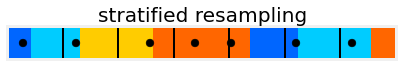

In [17]:
from pf_internal import plot_stratified_resample
plot_stratified_resample([.1, .2, .3, .4, .2, .3, .1])

The code to perform the stratification is quite straightforward. 

    def stratified_resample(weights):
        N = len(weights)
        # make N subdivisions, and chose a random position within each one
        positions = (random(N) + range(N)) / N

        indexes = np.zeros(N, 'i')
        cumulative_sum = np.cumsum(weights)
        i, j = 0, 0
        while i < N:
            if positions[i] < cumulative_sum[j]:
                indexes[i] = j
                i += 1
            else:
                j += 1
        return indexes

Import it from FilterPy with

    from filterpy.monte_carlo import stratified_resample

### Systematic Resampling

The last algorithm we will look at is systemic resampling. As with stratified resampling the space is divided into $N$ divisions. We then choose a random offset to use for all of the divisions, ensuring that each particle is exactly $\frac{1}{N}$ apart. It looks like this.

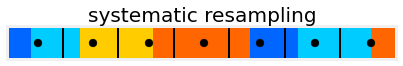

In [18]:
from pf_internal import plot_systematic_resample
plot_systematic_resample([.1, .2, .3, .4, .2, .3, .1])

The code couldn't be simpler.

    def systematic_resample(weights):
        N = len(weights)

        # make N subdivisions, choose positions with a consistent random offset
        positions = (np.arange(N) + random()) / N

        indexes = np.zeros(N, 'i')
        cumulative_sum = np.cumsum(weights)
        i, j = 0, 0
        while i < N:
            if positions[i] < cumulative_sum[j]:
                indexes[i] = j
                i += 1
            else:
                j += 1
        return indexes
        
Import from FilterPy with

     from filterpy.monte_carlo import systematic_resample

### Choosing a Resampling Algorithm

Let's look at the four algorithms at once so they are easier to compare.

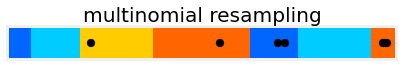

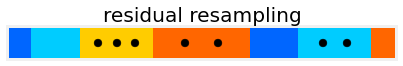

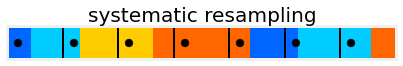

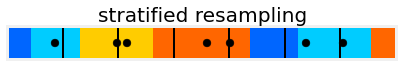

In [19]:
a = [.1, .2, .3, .4, .2, .3, .1]
np.random.seed(4)
plot_multinomial_resample(a)
plot_residual_resample(a)
plot_systematic_resample(a)
plot_stratified_resample(a)

The performance of the multinomial resampling is quite bad. There is a very large weight that was not sampled at all. The largest weight only got one resample, yet the smallest weight was sample was sampled twice. Most tutorials on the net that I have read use multinomial resampling, and I am not sure why. Multinomial rarely used in the literature or for real problems. I recommend not using it unless you have a very good reason to do so.

The residual resampling algorithm does excellently at what it tries to do: ensure all the largest weights are resampled multiple times. It does do well at evenly distributing the samples across the particles - many reasonably large weights are not resampled at all. 

Both systematic and stratified perform very well. Systematic sampling does an excellent job of ensuring we sample from all parts of the particle space while ensuring larger weights are proportionality resampled more often. Stratified resampling is not quite as uniform as systematic resampling, but it is a bit better at ensuring the higher weights get resampled more.

Plenty has been written on the theoretical performance of these algorithms, and feel free to read it.  In practice I apply particle filters to problems that resist analytic efforts, and so I feel a bit dubious about the validity of a specific analysis to these problems. In practice both the stratified and systematic algorithms perform well and very similarly across a variety of problems. I say try one, and if it works stick with it. If performance of the filter is critical try both, and perhaps see if there is literature published on your specific problem that will give you better guidance. 

### Types of Particle Filters

The idea behind particle filtering is quite straightforward. As a result the idea has been invented multiple times in different fields using different nomenclature. This gives the field a rather unsystematic organization that can be hard to summarize.

However, we can start with a few basics. The first term to understand is Sequential importance sampling (SIS). This is the particle filter presented above without resampling. As already discussed, it approximates the posterier distribution (the probability distribution after the measurement is incorporated) by drawing a sample of weighted particles via importance sampling. The particles are then recursively updated them based on the measurements. This algorithm quickly generates due to particle degeneracy, but the idea forms the backbone of all particle filters I am aware of.

The next particle filter is the Sampling Importance Resampling, or SIR. This is the particle filter that we implemented. It improves SIS by adding a resampling step that strives to duplicate particles with higher weights, and to kill of particles with lower weights. Though I have not emphasized this point, this can be viewed as an evolutionary algorithm where the fittest particles survive. Some of the literature takes that viewpoint, so if an article is talking about evolutionary MCMC methods you may want to check if they mean a particle filter. 

The SIR filter has various strengths and weaknesses. On the plus side it places very few restrictions on the problem. You need to know the behavior of the state model so that the particles can be propagated forward. You need to know the measurement functions so that measurements can be converted into state space. Finally, you need to be able to specify the likelihood function. A major weakness is that it performs resampling without taking the measurements into account. This is very inefficient -

## References

[1] *Importance Sampling*, Wikipedia.
https://en.wikipedia.org/wiki/Importance_sampling


